In [166]:
from skfdiff import Model, Simulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom


## Example 1: Turing Patterns

In [149]:
bc = {("U", "x"): ("dirichlet", "dirichlet"),
      ("U", "y"): ("dirichlet", "dirichlet"),
      ("V", "x"): ("dirichlet", "dirichlet"),
      ("V", "y"): ("dirichlet", "dirichlet")}

model = Model(
    ["alpha1*(dxxU + dyyU) + U^2*V - (a+b)*U",
     "alpha2*(dxxV + dyyV) -U^2*V + a*(1-V)"],
    ["U(x,y)",
    "V(x,y)"],
    parameters=["alpha1","alpha2","a","b"], boundary_conditions="periodic",backend="numpy")

In [169]:
dx = 5
dt = 5
L = 200
t_end = 800
x = np.arange(0, L, dx)
N_x = x.shape[0]
X, Y = np.meshgrid(x, x, indexing="ij")
u = np.random.random((N_x,N_x))
v = np.zeros((N_x,N_x))

alpha1 = 1
alpha2 = 10
a = 0.037
b = 0.06

initial_fields = model.Fields(x=x, y=x, U=u, V=v, alpha1=alpha1, alpha2=alpha2, a=a, b=b)


In [170]:
simulation = Simulation(model, initial_fields, dt=dt, tmax=t_end)
result = []
tList = []
for t, field in simulation:
    result.append(field)
    tList.append(t)

zoom_factor=5
uList = [zoom(result[i]["U"].values, zoom_factor, order=2) for i in range(len(result))]

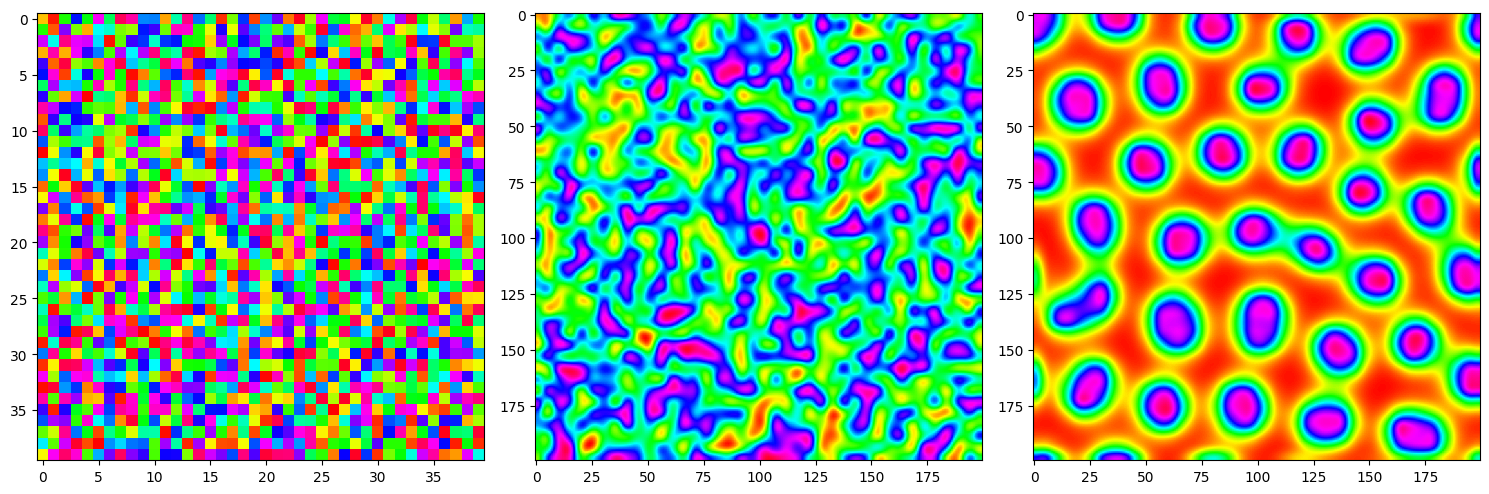

In [171]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im0 = axes[0].imshow(u, cmap='hsv')
im1 = axes[1].imshow(uList[0], cmap='hsv')
im2 =axes[2].imshow(uList[-1], cmap='hsv')


plt.tight_layout()
plt.show()

# Brusselator

In [299]:
bc = {("U", "x"): ("dirichlet", "dirichlet"),
      ("U", "y"): ("dirichlet", "dirichlet"),
      ("V", "x"): ("dirichlet", "dirichlet"),
      ("V", "y"): ("dirichlet", "dirichlet")}

model = Model(
    ["alpha1*(dxxU + dyyU) + a-(1+b)*U+V*U**2",
     "alpha2*(dxxV + dyyV) -U^2*V + b*U"],
    ["U(x,y)",
    "V(x,y)"],
    parameters=["alpha1","alpha2","a","b"], boundary_conditions="periodic",backend="numpy")

In [300]:
dx = 5
dt = 5
L = 200
t_end = 80
x = np.arange(0, L, dx)
N_x = x.shape[0]
X, Y = np.meshgrid(x, x, indexing="ij")
u = np.random.random((N_x,N_x))
v = np.zeros((N_x,N_x))

alpha1 = 1
alpha2 = 0.1
a = 1
b = 3

initial_fields = model.Fields(x=x, y=x, U=u, V=v, alpha1=alpha1, alpha2=alpha2, a=a, b=b)


In [301]:
simulation = Simulation(model, initial_fields, dt=dt, tmax=t_end)
result = []
tList = []
for t, field in simulation:
    result.append(field)
    tList.append(t)

zoom_factor=5
uList = [zoom(result[i]["U"].values, zoom_factor, order=2) for i in range(len(result))]

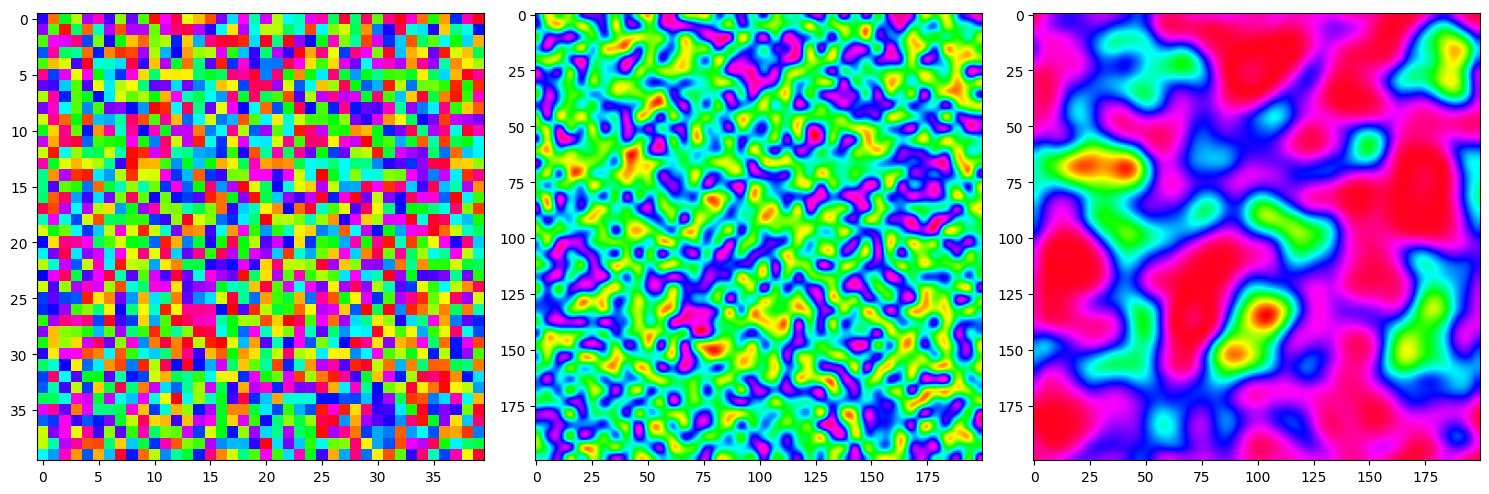

In [303]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im0 = axes[0].imshow(u, cmap='hsv')
im1 = axes[1].imshow(uList[0], cmap='hsv')
im2 =axes[2].imshow(uList[-1], cmap='hsv')


plt.tight_layout()
plt.show()

## Example 2: Circulating Field!
Consider the following PDE
$$ u_t = \nabla\cdot(\alpha\nabla u + n F) $$
where $F = (F_1,F_2)$ is a vector field where $n$ does chemotaxis in that direction.
We can re-write this equation as
$$ u_t = \alpha\nabla^2 u + \partial_x (nF_1) + \partial_y (nF_2) $$

In [209]:
def F_1(x,y):
    return -y/(x**2+y**2+0.01)**(1/2)
    
def F_2(x,y):
    return x/(x**2+y**2+0.01)**(1/2)

def I(x,y):
    r2 = (x-L/5)**2 + (y-L/2)**2
    return np.exp(-r2/(L/5)**2)

In [291]:
bc = {("n", "x"): ("dirichlet", "dirichlet"),
      ("n", "y"): ("dirichlet", "dirichlet"),}

# model = Model(
#     ["alpha*(dxx(n) + dyy(n)) + chi*dx(n*F_1) + chi*dy(n*F_2)"],
#     ["n(x,y)"],
#     parameters=["alpha","chi","F_1(x,y)","F_2(x,y)"], boundary_conditions=bc,backend="numpy")

# model = Model(
#     ["alpha*(dxx(n) + dyy(n)) + chi*upwind(1,n*F_1,x,1) + chi*upwind(1,n*F_2,y,1)"],
#     ["n(x,y)"],
#     parameters=["alpha","chi","F_1(x,y)","F_2(x,y)"], boundary_conditions=bc,backend="numpy")

model = Model(
    ["alpha*(dxx(n) + dyy(n)) + chi*(upwind(F_1,n,x,1)+n*dx(F_1))+ chi*(upwind(F_2,n,y,1)+n*dy(F_2))"],
    ["n(x,y)"],
    parameters=["alpha","chi","F_1(x,y)","F_2(x,y)"], boundary_conditions="periodic",backend="numba")

In [293]:
dx = 1
dt = 1
L = 10
t_end = 10
x = np.arange(0, L, dx)
y=x
N_x = x.shape[0]
X, Y = np.meshgrid(x, x, indexing="ij")
n= I(X,Y)

alpha = 0.1
chi = 1

initial_fields = model.Fields(x=x,y=y,n=n, alpha=alpha, chi=chi, F_1=F_1(X,Y), F_2=F_2(X,Y))

In [294]:
simulation = Simulation(model, initial_fields, dt=dt, tmax=t_end)
result = []
tList = []
for t, field in simulation:
    result.append(field)
    tList.append(t)



In [295]:
zoom_factor=5
uList = [zoom(result[i]["n"].values, zoom_factor, order=2) for i in range(len(result))]

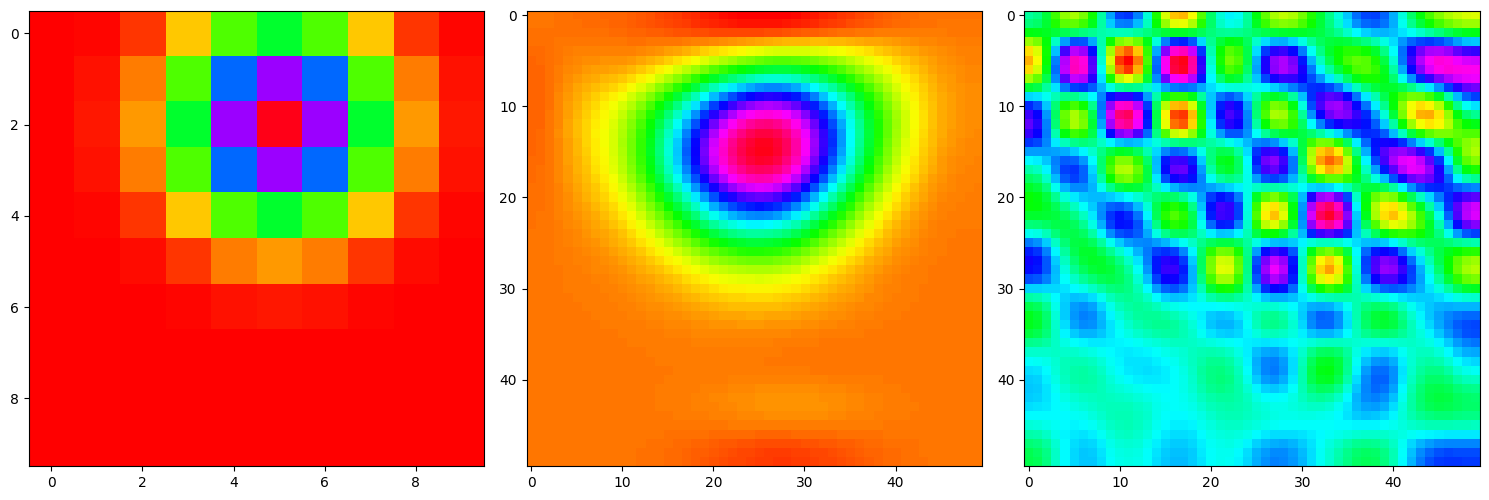

In [296]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im0 = axes[0].imshow(n, cmap='hsv')
im1 = axes[1].imshow(uList[0], cmap='hsv')
im2 =axes[2].imshow(uList[-1], cmap='hsv')


plt.tight_layout()
plt.show()

In [297]:
def update(frame):
    cax.set_array(uList[frame])
    return [cax]
    
%matplotlib notebook
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.imshow(uList[0], cmap='hsv')
fig.colorbar(cax)
ani = animation.FuncAnimation(fig, update, frames=len(uList), interval=1, blit=True)

HTML(ani.to_jshtml())

<IPython.core.display.Javascript object>